In [1]:
import pandas as pd
import os, pickle
import numpy as np
import pymongo

import sys
sys.path.append('../')
import src.IQ as IQ


myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/admin")
BLE = myclient["BLE"]

def query(collection, filter:dict, addFrameColumn=True):
    df =  pd.DataFrame(list(collection.find(filter)))
    if addFrameColumn:
        df['frame'] = df.apply(lambda x: x['I'] + np.dot(x['Q'],1j), axis=1)
    return df.copy()

2023-11-15 09:28:23.871993: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 09:28:23.896602: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 09:28:23.896627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 09:28:23.896645: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 09:28:23.901106: I tensorflow/core/platform/cpu_feature_g

2000
<class 'numpy.ndarray'>


2023-11-15 09:28:31.444209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1050)              2101050   
                                                                 
 dense_1 (Dense)             (None, 575)               604325    
                                                                 
 dense_2 (Dense)             (None, 101)               58176     
                                                                 
 dense_3 (Dense)             (None, 575)               58650     
                                                                 
 dense_4 (Dense)             (None, 1050)              604800    
                                                                 
 dense_5 (Dense)             (None, 2000)              210200

2023-11-15 09:28:31.447927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-15 09:28:31.448014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-15 09:28:31.449440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

10/10 [==============================] - 2s 16ms/step - loss: 3.1894 - val_loss: 1.4638
Epoch 2/2048
10/10 [==============================] - 0s 6ms/step - loss: 1.2879 - val_loss: 1.4527
Epoch 3/2048
10/10 [==============================] - 0s 6ms/step - loss: 1.0990 - val_loss: 0.8111
Epoch 4/2048
10/10 [==============================] - 0s 6ms/step - loss: 0.8118 - val_loss: 0.6873
Epoch 5/2048
10/10 [==============================] - 0s 6ms/step - loss: 0.6875 - val_loss: 0.6407
Epoch 6/2048
10/10 [==============================] - 0s 6ms/step - loss: 0.7236 - val_loss: 1.1805
Epoch 7/2048
10/10 [==============================] - 0s 6ms/step - loss: 0.7755 - val_loss: 0.9821
Epoch 8/2048
10/10 [==============================] - 0s 6ms/step - loss: 0.7796 - val_loss: 0.7515
Epoch 9/2048
10/10 [==============================] - 0s 6ms/step - loss: 0.6295 - val_loss: 0.5811
Epoch 10/2048
10/10 [==============================] - 0s 7ms/step - loss: 0.6211 - val_loss: 0.5849
Epoch 11/20

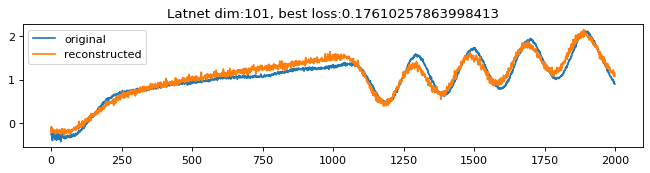

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1051)              2103051   
                                                                 
 dense_1 (Dense)             (None, 576)               605952    
                                                                 
 dense_2 (Dense)             (None, 102)               58854     
                                                                 
 dense_3 (Dense)             (None, 576)               59328     
                                                                 
 dense_4 (Dense)             (None, 1051)              606427    
                                                                 
 dense_5 (Dense)             (None, 2000)              210400

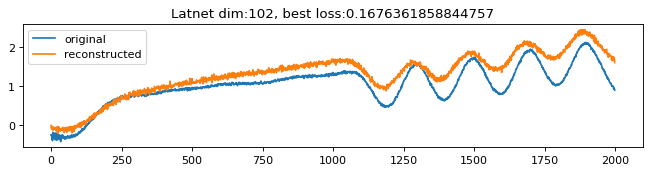

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1051)              2103051   
                                                                 
 dense_1 (Dense)             (None, 577)               607004    
                                                                 
 dense_2 (Dense)             (None, 103)               59534     
                                                                 
 dense_3 (Dense)             (None, 577)               60008     
                                                                 
 dense_4 (Dense)             (None, 1051)              607478    
                                                                 
 dense_5 (Dense)             (None, 2000)              210400

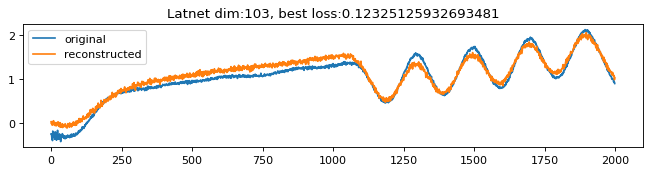

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1052)              2105052   
                                                                 
 dense_1 (Dense)             (None, 578)               608634    
                                                                 
 dense_2 (Dense)             (None, 104)               60216     
                                                                 
 dense_3 (Dense)             (None, 578)               60690     
                                                                 
 dense_4 (Dense)             (None, 1052)              609108    
                                                                 
 dense_5 (Dense)             (None, 2000)              210600

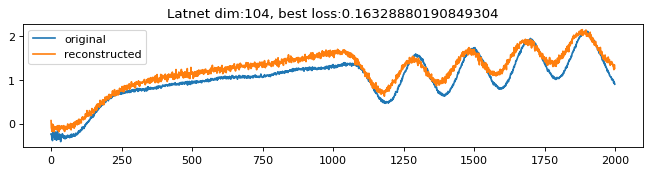

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1052)              2105052   
                                                                 
 dense_1 (Dense)             (None, 578)               608634    
                                                                 
 dense_2 (Dense)             (None, 105)               60795     
                                                                 
 dense_3 (Dense)             (None, 578)               61268     
                                                                 
 dense_4 (Dense)             (None, 1052)              609108    
                                                                 
 dense_5 (Dense)             (None, 2000)              210600

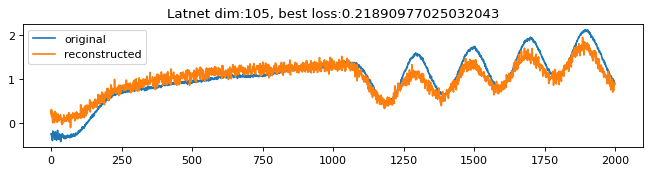

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1053)              2107053   
                                                                 
 dense_1 (Dense)             (None, 579)               610266    
                                                                 
 dense_2 (Dense)             (None, 106)               61480     
                                                                 
 dense_3 (Dense)             (None, 579)               61953     
                                                                 
 dense_4 (Dense)             (None, 1053)              610740    
                                                                 
 dense_5 (Dense)             (None, 2000)              210800

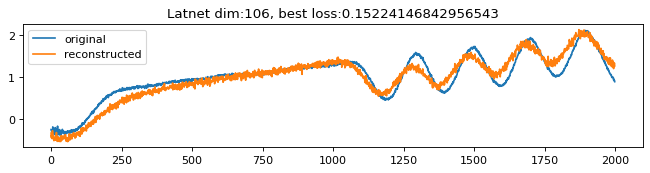

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1053)              2107053   
                                                                 
 dense_1 (Dense)             (None, 580)               611320    
                                                                 
 dense_2 (Dense)             (None, 107)               62167     
                                                                 
 dense_3 (Dense)             (None, 580)               62640     
                                                                 
 dense_4 (Dense)             (None, 1053)              611793    
                                                                 
 dense_5 (Dense)             (None, 2000)              210800

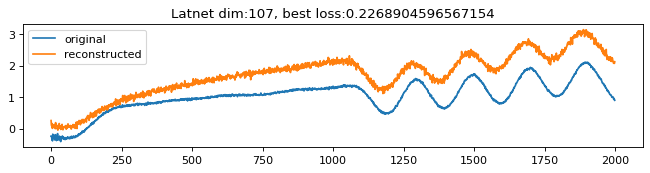

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1054)              2109054   
                                                                 
 dense_1 (Dense)             (None, 581)               612955    
                                                                 
 dense_2 (Dense)             (None, 108)               62856     
                                                                 
 dense_3 (Dense)             (None, 581)               63329     
                                                                 
 dense_4 (Dense)             (None, 1054)              613428    
                                                                 
 dense_5 (Dense)             (None, 2000)              211000

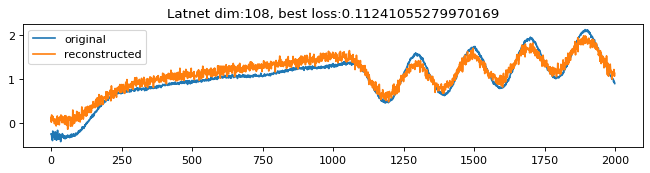

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1054)              2109054   
                                                                 
 dense_1 (Dense)             (None, 581)               612955    
                                                                 
 dense_2 (Dense)             (None, 109)               63438     
                                                                 
 dense_3 (Dense)             (None, 581)               63910     
                                                                 
 dense_4 (Dense)             (None, 1054)              613428    
                                                                 
 dense_5 (Dense)             (None, 2000)              211000

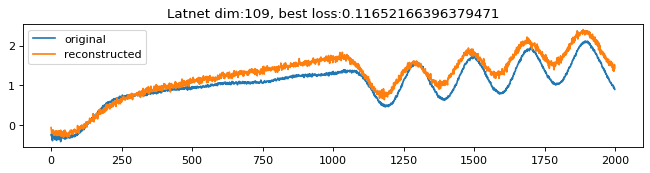

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1055)              2111055   
                                                                 
 dense_1 (Dense)             (None, 582)               614592    
                                                                 
 dense_2 (Dense)             (None, 110)               64130     
                                                                 
 dense_3 (Dense)             (None, 582)               64602     
                                                                 
 dense_4 (Dense)             (None, 1055)              615065    
                                                                 
 dense_5 (Dense)             (None, 2000)              211200

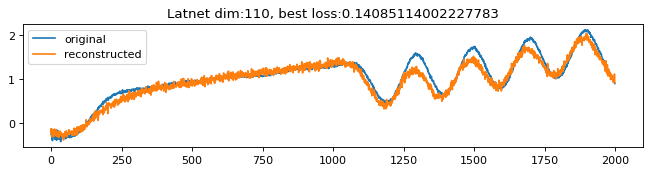

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1055)              2111055   
                                                                 
 dense_1 (Dense)             (None, 583)               615648    
                                                                 
 dense_2 (Dense)             (None, 111)               64824     
                                                                 
 dense_3 (Dense)             (None, 583)               65296     
                                                                 
 dense_4 (Dense)             (None, 1055)              616120    
                                                                 
 dense_5 (Dense)             (None, 2000)              211200

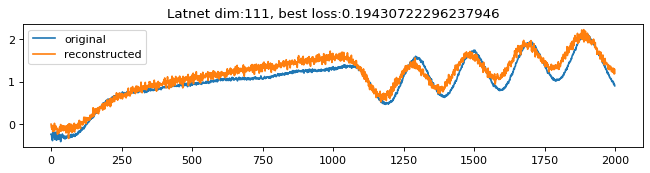

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1056)              2113056   
                                                                 
 dense_1 (Dense)             (None, 584)               617288    
                                                                 
 dense_2 (Dense)             (None, 112)               65520     
                                                                 
 dense_3 (Dense)             (None, 584)               65992     
                                                                 
 dense_4 (Dense)             (None, 1056)              617760    
                                                                 
 dense_5 (Dense)             (None, 2000)              211400

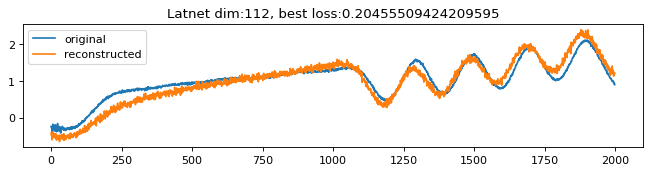

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1056)              2113056   
                                                                 
 dense_1 (Dense)             (None, 584)               617288    
                                                                 
 dense_2 (Dense)             (None, 113)               66105     
                                                                 
 dense_3 (Dense)             (None, 584)               66576     
                                                                 
 dense_4 (Dense)             (None, 1056)              617760    
                                                                 
 dense_5 (Dense)             (None, 2000)              211400

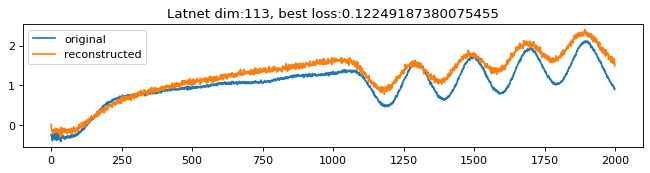

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1057)              2115057   
                                                                 
 dense_1 (Dense)             (None, 585)               618930    
                                                                 
 dense_2 (Dense)             (None, 114)               66804     
                                                                 
 dense_3 (Dense)             (None, 585)               67275     
                                                                 
 dense_4 (Dense)             (None, 1057)              619402    
                                                                 
 dense_5 (Dense)             (None, 2000)              211600

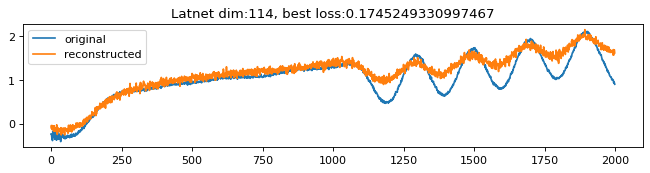

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1057)              2115057   
                                                                 
 dense_1 (Dense)             (None, 586)               619988    
                                                                 
 dense_2 (Dense)             (None, 115)               67505     
                                                                 
 dense_3 (Dense)             (None, 586)               67976     
                                                                 
 dense_4 (Dense)             (None, 1057)              620459    
                                                                 
 dense_5 (Dense)             (None, 2000)              211600

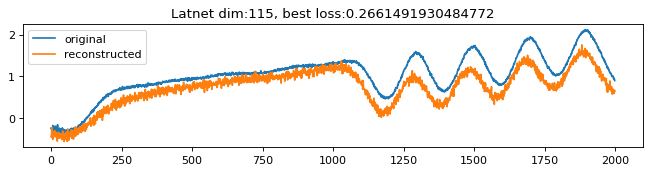

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1058)              2117058   
                                                                 
 dense_1 (Dense)             (None, 587)               621633    
                                                                 
 dense_2 (Dense)             (None, 116)               68208     
                                                                 
 dense_3 (Dense)             (None, 587)               68679     
                                                                 
 dense_4 (Dense)             (None, 1058)              622104    
                                                                 
 dense_5 (Dense)             (None, 2000)              211800

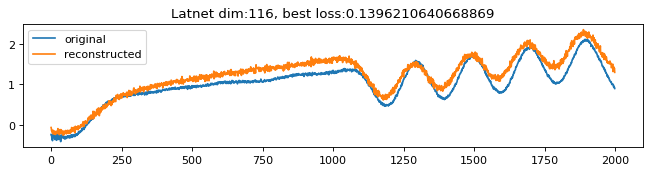

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1058)              2117058   
                                                                 
 dense_1 (Dense)             (None, 587)               621633    
                                                                 
 dense_2 (Dense)             (None, 117)               68796     
                                                                 
 dense_3 (Dense)             (None, 587)               69266     
                                                                 
 dense_4 (Dense)             (None, 1058)              622104    
                                                                 
 dense_5 (Dense)             (None, 2000)              211800

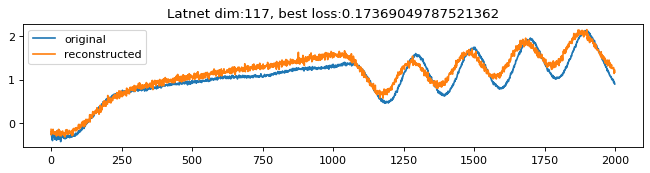

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1059)              2119059   
                                                                 
 dense_1 (Dense)             (None, 588)               623280    
                                                                 
 dense_2 (Dense)             (None, 118)               69502     
                                                                 
 dense_3 (Dense)             (None, 588)               69972     
                                                                 
 dense_4 (Dense)             (None, 1059)              623751    
                                                                 
 dense_5 (Dense)             (None, 2000)              212000

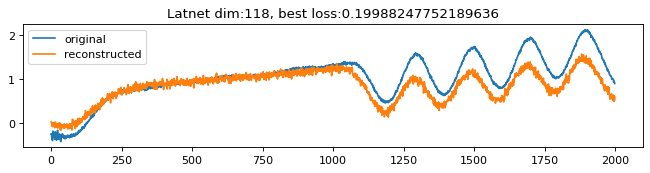

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1059)              2119059   
                                                                 
 dense_1 (Dense)             (None, 589)               624340    
                                                                 
 dense_2 (Dense)             (None, 119)               70210     
                                                                 
 dense_3 (Dense)             (None, 589)               70680     
                                                                 
 dense_4 (Dense)             (None, 1059)              624810    
                                                                 
 dense_5 (Dense)             (None, 2000)              212000

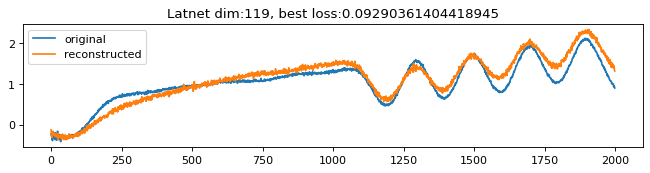

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1060)              2121060   
                                                                 
 dense_1 (Dense)             (None, 590)               625990    
                                                                 
 dense_2 (Dense)             (None, 120)               70920     
                                                                 
 dense_3 (Dense)             (None, 590)               71390     
                                                                 
 dense_4 (Dense)             (None, 1060)              626460    
                                                                 
 dense_5 (Dense)             (None, 2000)              212200

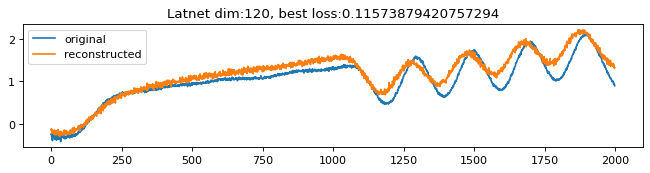

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1060)              2121060   
                                                                 
 dense_1 (Dense)             (None, 590)               625990    
                                                                 
 dense_2 (Dense)             (None, 121)               71511     
                                                                 
 dense_3 (Dense)             (None, 590)               71980     
                                                                 
 dense_4 (Dense)             (None, 1060)              626460    
                                                                 
 dense_5 (Dense)             (None, 2000)              212200

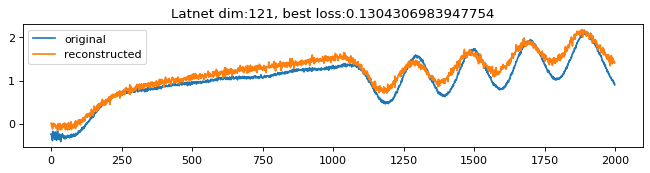

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1061)              2123061   
                                                                 
 dense_1 (Dense)             (None, 591)               627642    
                                                                 
 dense_2 (Dense)             (None, 122)               72224     
                                                                 
 dense_3 (Dense)             (None, 591)               72693     
                                                                 
 dense_4 (Dense)             (None, 1061)              628112    
                                                                 
 dense_5 (Dense)             (None, 2000)              212400

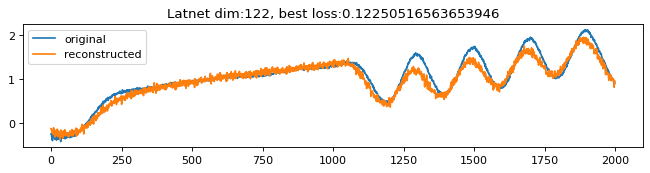

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1061)              2123061   
                                                                 
 dense_1 (Dense)             (None, 592)               628704    
                                                                 
 dense_2 (Dense)             (None, 123)               72939     
                                                                 
 dense_3 (Dense)             (None, 592)               73408     
                                                                 
 dense_4 (Dense)             (None, 1061)              629173    
                                                                 
 dense_5 (Dense)             (None, 2000)              212400

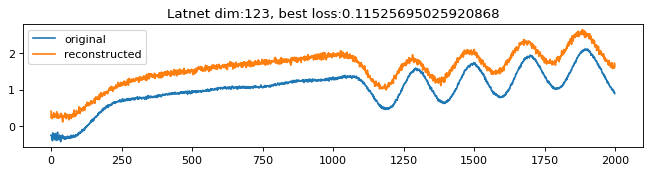

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1062)              2125062   
                                                                 
 dense_1 (Dense)             (None, 593)               630359    
                                                                 
 dense_2 (Dense)             (None, 124)               73656     
                                                                 
 dense_3 (Dense)             (None, 593)               74125     
                                                                 
 dense_4 (Dense)             (None, 1062)              630828    
                                                                 
 dense_5 (Dense)             (None, 2000)              212600

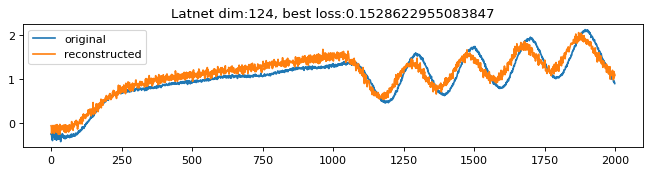

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1062)              2125062   
                                                                 
 dense_1 (Dense)             (None, 593)               630359    
                                                                 
 dense_2 (Dense)             (None, 125)               74250     
                                                                 
 dense_3 (Dense)             (None, 593)               74718     
                                                                 
 dense_4 (Dense)             (None, 1062)              630828    
                                                                 
 dense_5 (Dense)             (None, 2000)              212600

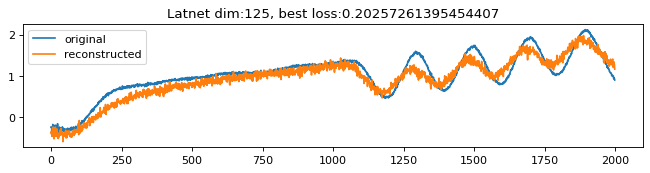

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1063)              2127063   
                                                                 
 dense_1 (Dense)             (None, 594)               632016    
                                                                 
 dense_2 (Dense)             (None, 126)               74970     
                                                                 
 dense_3 (Dense)             (None, 594)               75438     
                                                                 
 dense_4 (Dense)             (None, 1063)              632485    
                                                                 
 dense_5 (Dense)             (None, 2000)              212800

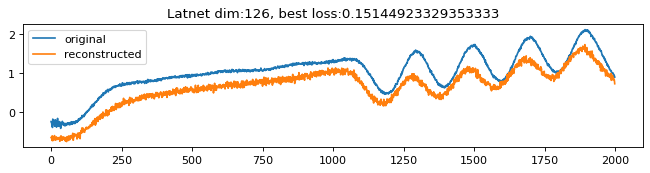

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1063)              2127063   
                                                                 
 dense_1 (Dense)             (None, 595)               633080    
                                                                 
 dense_2 (Dense)             (None, 127)               75692     
                                                                 
 dense_3 (Dense)             (None, 595)               76160     
                                                                 
 dense_4 (Dense)             (None, 1063)              633548    
                                                                 
 dense_5 (Dense)             (None, 2000)              212800

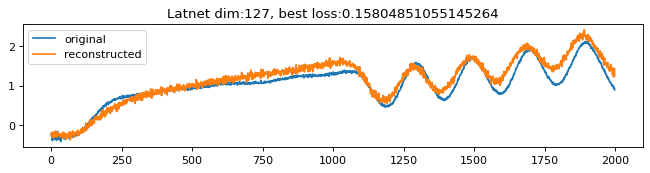

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1064)              2129064   
                                                                 
 dense_1 (Dense)             (None, 596)               634740    
                                                                 
 dense_2 (Dense)             (None, 128)               76416     
                                                                 
 dense_3 (Dense)             (None, 596)               76884     
                                                                 
 dense_4 (Dense)             (None, 1064)              635208    
                                                                 
 dense_5 (Dense)             (None, 2000)              213000

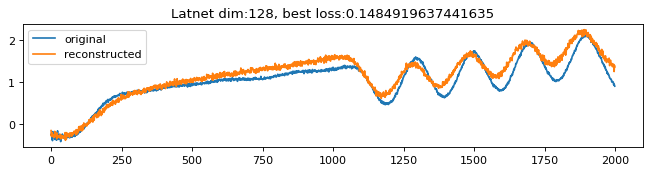

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1064)              2129064   
                                                                 
 dense_1 (Dense)             (None, 596)               634740    
                                                                 
 dense_2 (Dense)             (None, 129)               77013     
                                                                 
 dense_3 (Dense)             (None, 596)               77480     
                                                                 
 dense_4 (Dense)             (None, 1064)              635208    
                                                                 
 dense_5 (Dense)             (None, 2000)              213000

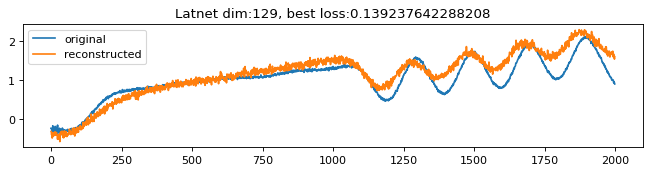

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1065)              2131065   
                                                                 
 dense_1 (Dense)             (None, 597)               636402    
                                                                 
 dense_2 (Dense)             (None, 130)               77740     
                                                                 
 dense_3 (Dense)             (None, 597)               78207     
                                                                 
 dense_4 (Dense)             (None, 1065)              636870    
                                                                 
 dense_5 (Dense)             (None, 2000)              213200

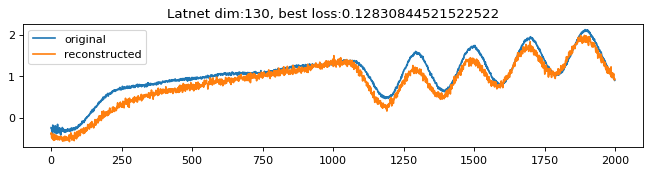

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1065)              2131065   
                                                                 
 dense_1 (Dense)             (None, 598)               637468    
                                                                 
 dense_2 (Dense)             (None, 131)               78469     
                                                                 
 dense_3 (Dense)             (None, 598)               78936     
                                                                 
 dense_4 (Dense)             (None, 1065)              637935    
                                                                 
 dense_5 (Dense)             (None, 2000)              213200

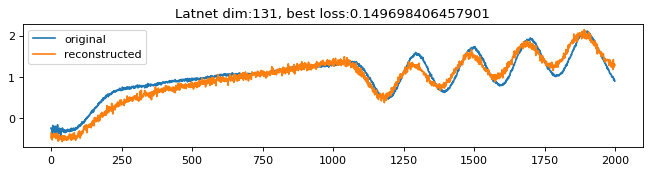

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1066)              2133066   
                                                                 
 dense_1 (Dense)             (None, 599)               639133    
                                                                 
 dense_2 (Dense)             (None, 132)               79200     
                                                                 
 dense_3 (Dense)             (None, 599)               79667     
                                                                 
 dense_4 (Dense)             (None, 1066)              639600    
                                                                 
 dense_5 (Dense)             (None, 2000)              213400

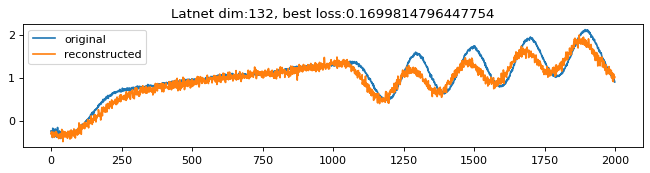

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1066)              2133066   
                                                                 
 dense_1 (Dense)             (None, 599)               639133    
                                                                 
 dense_2 (Dense)             (None, 133)               79800     
                                                                 
 dense_3 (Dense)             (None, 599)               80266     
                                                                 
 dense_4 (Dense)             (None, 1066)              639600    
                                                                 
 dense_5 (Dense)             (None, 2000)              213400

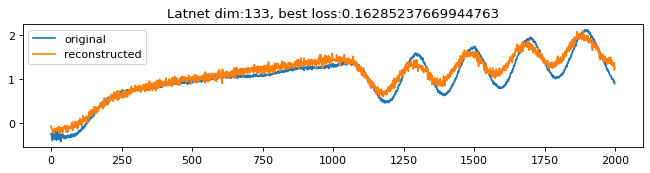

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1067)              2135067   
                                                                 
 dense_1 (Dense)             (None, 600)               640800    
                                                                 
 dense_2 (Dense)             (None, 134)               80534     
                                                                 
 dense_3 (Dense)             (None, 600)               81000     
                                                                 
 dense_4 (Dense)             (None, 1067)              641267    
                                                                 
 dense_5 (Dense)             (None, 2000)              213600

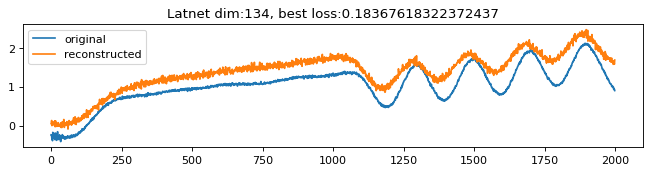

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1067)              2135067   
                                                                 
 dense_1 (Dense)             (None, 601)               641868    
                                                                 
 dense_2 (Dense)             (None, 135)               81270     
                                                                 
 dense_3 (Dense)             (None, 601)               81736     
                                                                 
 dense_4 (Dense)             (None, 1067)              642334    
                                                                 
 dense_5 (Dense)             (None, 2000)              213600

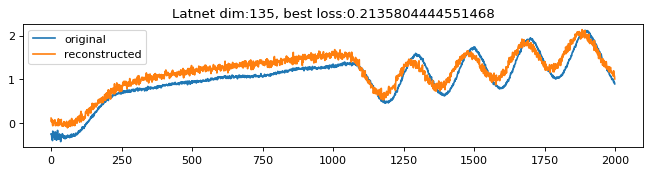

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1068)              2137068   
                                                                 
 dense_1 (Dense)             (None, 602)               643538    
                                                                 
 dense_2 (Dense)             (None, 136)               82008     
                                                                 
 dense_3 (Dense)             (None, 602)               82474     
                                                                 
 dense_4 (Dense)             (None, 1068)              644004    
                                                                 
 dense_5 (Dense)             (None, 2000)              213800

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l1, l2
import threading
from sklearn.preprocessing import MinMaxScaler





# We will start with a size that is approximately half of the input size
def run(encoding_dim,input_tensor_features,output_tensor_features, plot = False):
    input_shape = input_tensor_features[0].shape[0]
    output_shape = output_tensor_features[0].shape[0]
    input_data = Input(shape=(input_shape,))
    encoded = Dense(encoding_dim + (input_shape - encoding_dim )//2, activation='relu')(input_data)
    encoded = Dense(encoding_dim + (input_shape - encoding_dim )//4, activation='tanh')(encoded)
    
    encoded = Dense(encoding_dim, activation='linear')(encoded) # kernel_regularizer=l1(0.01)


    decoded = Dense(encoding_dim + (output_shape - encoding_dim )//4, activation='tanh')(encoded) 
    decoded = Dense(encoding_dim + (output_shape - encoding_dim )//2, activation='relu')(decoded)
    decoded = Dense(output_shape, activation='linear')(decoded)

    # This model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded)

    # This model maps an input to its encoded representation
    # encoder = Model(input_data, encoded)

    # Compile the model
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Display the architecture of the autoencoder
    with lock:
        autoencoder.summary()

    # Train the autoencoder
    # We will use new_csv_features as both the input and the target since it's an autoencoder

    early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=0)

    # Train the autoencoder and save the history
    history = autoencoder.fit(input_tensor_features, output_tensor_features,
                            epochs=2048,
                            batch_size=256,
                            shuffle=True,
                            validation_split=0.2,
                            callbacks=[early_stopping],
                            verbose=1,
                            )  # Set verbose to 1 for progress output




    best_loss = min(history.history['val_loss']) # this is the raining loss
    best_losses[encoding_dim] = best_loss
    print("latent dim:", encoding_dim, "loss value is: ", best_loss)

    if plot:
        lock.acquire()
        plt.figure(figsize=(10, 2),dpi=80)
        plt.plot(output_tensor_features[199], label='original')
        plt.plot(autoencoder(input_tensor_features)[199], label='reconstructed')
        plt.title('Latnet dim:'+ str(encoding_dim)+", best loss:"+str(best_loss)) 
        plt.legend()
        plt.show()
        plt.close()

        # plt.figure(figsize=(20, 4))
        # for i in range (1,len(autoencoder.layers)-1):
        # # Assuming 'autoencoder' is your trained model and 'layer_index' is the index of the layer you want to analyze
        #     weights = autoencoder.layers[i].get_weights()[0]  # 0 for weights, 1 for biases

        #     # Plotting the weights as a heatmap
            
        #     plt.subplot(1,len(autoencoder.layers)-2,i)
        #     plt.imshow(weights, cmap='viridis', aspect='auto')
        #     plt.colorbar()

        # plt.show()
        # plt.close()

        # plt.figure(figsize=(10, 16))
        # for i in range (1,len(autoencoder.layers)-1):
        # # Assuming 'autoencoder' is your trained model and 'layer_index' is the index of the layer you want to analyze
        #     weights = autoencoder.layers[i].get_weights()[0]  # 0 for weights, 1 for biases
        #     biases = autoencoder.layers[i].get_weights()[1]  # 0 for weights, 1 for biases
        #     # Histogram of the weight values
        #     plt.subplot(2*(len(autoencoder.layers)-2),1,i*2-1)
        #     plt.plot(weights.flatten().tolist(), label='weights')
        #     plt.plot(np.linspace(0,len(weights.flatten()),len(biases.flatten())),biases.flatten().tolist(), label='biases')
        #     plt.legend()
        #     plt.subplot(2*(len(autoencoder.layers)-2),2,i*4-1)
        #     plt.hist(weights.flatten(), bins=50)

            
        #     # Histogram of the biases values
        #     plt.subplot(2*(len(autoencoder.layers)-2),2,i*4)
        #     plt.hist(biases.flatten(), bins=50)

        # plt.show()
        # plt.close()

        lock.release()
    tf.keras.backend.clear_session()
    clear_session()




# Create a StandardScaler object
scaler = StandardScaler()
scaler2 = MinMaxScaler(feature_range=(0, 1))
# Assuming 'new_csv_features' is your data
def normalized(row):
    row = np.array(row)
    return scaler2.fit_transform(scaler.fit_transform(row.reshape(-1, 1)))

def fft_normalized(row):
    row = np.array(row)
    temp = np.fft.fft(row)[0:len(row)//2 + 1]

    amp = normalized(np.abs(temp))
    filtering = amp > np.average(amp)*.05
    angle = normalized(np.angle(temp))

    angle = angle[filtering] 
    angle = np.concatenate([angle,np.zeros(len(row)-len(angle))])
    amp = amp[filtering] 
    amp = np.concatenate([amp,np.zeros(len(row)-len(amp))])
    
    return np.concatenate([amp,angle])

lock = threading.Lock()
batch_size = 1

filtering = {''}
df = query(BLE['onBody'], {'pos':'static','antenna_side':'left'})
min_length = df['frame'].apply(len).min()
df['data'] = df['frame'].apply(lambda x: x[:2000])
print(len(df['data'][0]))
print(type(df['data'][0]))

iq = IQ.IQ(Fc=2439810000+1.5e4,Fs=100e6)

def configCreator(downSampleRate = 1, cutoff = 1e6):
    downSampleRate= max(downSampleRate, 1)
    return {                                      
            # iq.gradient:{},
            iq.unwrapPhase:{},
            iq.phase:{}, 
            # iq.butter:{'Fs': iq.Fs/downSampleRate, "cutoff": cutoff},
            iq.downSample:{'downSampleRate':downSampleRate, "shift": 0},
            iq.demodulate:{'Fs': iq.Fs},
           } 

methods = configCreator(downSampleRate=  1)
df['data'] = iq.apply(methods = methods, frame = df['data'])
####################################################################################
# df['normalized'] = df['predictor'].apply(lambda x: normalized(x))

df['normalized'] = df['data'].apply(lambda x: fft_normalized(x))
input_tensor_features = tf.convert_to_tensor(df['normalized'].tolist())

df['normalized'] = df['data']#.apply(lambda x: normalized(x))
output_tensor_features = tf.convert_to_tensor(df['normalized'].tolist())

data_shape = len(df['data'][0])
#####################################################################################

best_losses = {}
for batch in range(100,int(np.ceil(data_shape/batch_size))):
    threads = []
    for i in range(batch_size * batch+1, min(batch_size * batch+batch_size+1,data_shape)):
        threads.append(threading.Thread(target=run, args=(i,output_tensor_features,output_tensor_features,True, )))
        threads[-1].start()
    for t in threads:
        t.join()

best_losses = dict(sorted(best_losses.items()))
lossDF = pd.DataFrame(best_losses.values(),index=best_losses.keys())
lossDF.plot()
lossDF.to_csv('loss.csv')
plt.xlabel('Latent dimension')
plt.ylabel('Best loss')
# plt.title('dataset: '+filename)
# plt.savefig('res/'+filename+'.png')
plt.show()
plt.close()

In [ ]:
len(df['I'][0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

row =np.random.rand(10) 

filename = files[3]
print(filename)
f = open(dataDir+filename, 'rb')
data_tuples = pickle.load(f)
f.close()

df = pd.DataFrame(data_tuples, columns=['predictor', 'label'])

def fft_normalized(row):
    temp = np.fft.fft(row)[0:len(row)//2 + 1]
    amp = normalized(np.abs(temp))
    filtering = amp > np.max(amp)*0.05 

    angle = normalized(np.angle(temp))
    angle = angle[filtering]
    amp = amp[filtering]

    return np.concatenate([amp,angle])


df['normalized'] = df['predictor'].apply(lambda x: fft_normalized(x))
tf.convert_to_tensor( df['normalized'].to_list())


In [ ]:
# best_losses = dict(sorted(best_losses.items()))
# lossDF = pd.DataFrame(best_losses.values(),index=best_losses.keys())

def read_loss(file :str | os.DirEntry):
    if type(file) is str:
        if file.endswith(".csv"):
            lossDF = pd.read_csv(file,index_col=0)
            return lossDF
    else:
        if file.name.endswith(".csv"):
            lossDF = pd.read_csv(file.path,index_col=0)
            return lossDF

def plot_loss(file):
        read_loss(file)
        lossDF.plot()
        plt.xlabel('Latent dimension')
        plt.ylabel('Best loss')
        plt.title('dataset: '+file.name)
        plt.savefig('res/'+file.name+'.png')
        plt.show()
        plt.close()

# for file in os.scandir('res/RAE-_l2-0.001/'):
df = read_loss("loss_dataset1.pkl.csv")
import scipy.signal as signal

def smooth(x,window_len=11,window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError(f"Window is on of '{window}'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval(f'np.{window}({window_len})')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

plt.plot(smooth(df['0'].to_numpy(),window_len=5, window='hamming'))

